In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
from nltk.tokenize import word_tokenize

In [28]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [29]:
QuoraQuestions = pd.read_csv(r'E:\Data Science\Final DS Projects\AI Projects\QuoraSpam filter\train.csv')

In [30]:
print("Total Quora questions {0}".format(QuoraQuestions.shape[0]))

Total Quora questions 1306122


In [31]:
pd.options.display.max_colwidth = 0

In [32]:
QuoraQuestions.head(15)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?",0
6,00005059a06ee19e11ad,"Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?",0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off? Germs are everywhere.,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?",0
9,00006e6928c5df60eacb,"Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things change?",0


In [33]:
QuoraQuestions.dtypes

qid              object
question_text    object
target           int64 
dtype: object

In [34]:
QuoraQuestions.shape

(1306122, 3)

In [35]:
# removing the Math question, that doesn't  make any sensible sequence to learn.
QuoraQuestions = QuoraQuestions[QuoraQuestions['question_text'].str.contains("\[math\]",na=False) != True]


In [ ]:
#re.sub('\[math\].*?\[/math\]',''QuoraQuestionsoraQuestionsuoraQuestions['question_text'].str.contains("\[math\]",na=False),flags=re.DOTALL)

In [36]:
QuoraQuestions.shape

(1305387, 3)

In [37]:
QuoraQuestions['target'].value_counts()

0    1224622
1    80765  
Name: target, dtype: int64

In [38]:
QuoraQuestions.shape

(1305387, 3)

In [39]:
QuoraQuestions['question_text'].nunique()

1305387

In [40]:
# Dropping Quora question id (qid), since its unique and do not contribute to model.
QuoraQuestions.drop(['qid'],axis=1,inplace=True)

# Removing special characters

In [41]:
def remove_hyperLink(word):
    return re.sub(r"https\S+"," ",word)

In [42]:
def to_lower(word):
    result = word.lower()
    return result

In [43]:
def remove_Number(word):
    result = re.sub(r'\d+',' ',word)
    return result

In [44]:
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [45]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [46]:
def replace_newline(word):
    return word.replace('\n',' ')

In [47]:
def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperLink,
                      replace_newline,
                      to_lower,
                      remove_Number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [48]:
QuoraQuestions['question_text'] = [clean_up_pipeline(Q) for Q in QuoraQuestions['question_text']]

In [49]:
QuoraQuestions[QuoraQuestions['target'] == 1]

,question_text,target
22,has the united states become the largest dictatorship in the world,1
30,which babies are more sweeter to their parents dark skin babies or light skin babies,1
110,if blacks support school choice and mandatory sentencing for criminals why dont they vote republican,1
114,i am gay boy and i love my cousin boy he is sexy but i dont know what to do he is hot and i want to see his di what should i do,1
115,which races have the smallest penis,1
119,why do females find penises ugly,1
127,how do i marry an american woman for a green card how much do they charge,1
144,why do europeans say theyre the superior race when in fact it took them over years until mid th century to surpass chinas largest economy,1
156,did julius caesar bring a tyrannosaurus rex on his campaigns to frighten the celts into submission,1
167,in what manner has republican backing of states rights been hypocritical and what ways have they actually restricted the ability of states to make their own laws,1


# converting to word tokens

In [50]:
#Word processing
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [51]:
#stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [52]:
QuoraQuestions['question_text'] = [word_tokenize(Q) for Q in QuoraQuestions['question_text']]

In [53]:
QuoraQuestions[QuoraQuestions['target'] == 1]

,question_text,target
22,"[has, the, united, states, become, the, largest, dictatorship, in, the, world]",1
30,"[which, babies, are, more, sweeter, to, their, parents, dark, skin, babies, or, light, skin, babies]",1
110,"[if, blacks, support, school, choice, and, mandatory, sentencing, for, criminals, why, dont, they, vote, republican]",1
114,"[i, am, gay, boy, and, i, love, my, cousin, boy, he, is, sexy, but, i, dont, know, what, to, do, he, is, hot, and, i, want, to, see, his, di, what, should, i, do]",1
115,"[which, races, have, the, smallest, penis]",1
119,"[why, do, females, find, penises, ugly]",1
127,"[how, do, i, marry, an, american, woman, for, a, green, card, how, much, do, they, charge]",1
144,"[why, do, europeans, say, theyre, the, superior, race, when, in, fact, it, took, them, over, years, until, mid, th, century, to, surpass, chinas, largest, economy]",1
156,"[did, julius, caesar, bring, a, tyrannosaurus, rex, on, his, campaigns, to, frighten, the, celts, into, submission]",1
167,"[in, what, manner, has, republican, backing, of, states, rights, been, hypocritical, and, what, ways, have, they, actually, restricted, the, ability, of, states, to, make, their, own, laws]",1


# remove stop words, stemming and lemmatization

In [54]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [77]:
def remove_onecharacters(words):
    result = [i for i in words if len(i)>1]
    return result

In [78]:
def word_lemmatizer(words):
    return [lemmatizer.lemmatize(o) for o in words]

In [80]:
def clean_token_pipeline(words):
    cleaning_utils = [remove_stop_words,word_lemmatizer,remove_onecharacters]
    for o in cleaning_utils:
        words = o(words)
    return words

In [81]:
QuoraQuestions['question_text'] = [clean_token_pipeline(w) for w in QuoraQuestions['question_text']]

In [82]:
QuoraQuestions[QuoraQuestions['target'] == 0]

,question_text,target
0,"[did, quebec, nationalist, province, nation]",0
1,"[adopted, dog, encourage, people, adopt, shop]",0
2,"[doe, velocity, affect, time, doe, velocity, affect, space, geometry]",0
3,"[did, otto, von, guericke, used, magdeburg, hemisphere]",0
4,"[convert, montra, helicon, mountain, bike, just, changing, tyre]",0
5,"[gaza, slowly, auschwitz, dachau, treblinka, palestinian]",0
6,"[doe, quora, automatically, ban, conservative, opinion, reported, doe, liberal, view]",0
7,"[crazy, wash, wipe, grocery, germ]",0
8,"[thing, dressing, moderately, different, dressing, modestly]",0
9,"[just, phase, ignorant, people, loved, completely, disregarding, feelingslives, way, feel, temporarily, ease, did, thing, change]",0


In [83]:
bigListLength = 0
for i in range(QuoraQuestions.shape[0]):
    temp = len(QuoraQuestions['question_text'].iloc[i])
    if temp > bigListLength:
        bigListLength = temp
        rowNumber = i
print(" highest number of tokens {0} in rowNumber {1}".format(bigListLength,rowNumber))

 highest number of tokens 69 in rowNumber 521967


In [84]:
QuoraQuestions['question_text'].iloc[521967]


['star',
 'trek',
 'did',
 'spoiler',
 'spoiler',
 'spoiler',
 'spoiler',
 'make',
 'warping',
 'look',
 'quite',
 'bit',
 'like',
 'hyperspace',
 'jump',
 'world',
 'bright',
 'particle',
 'soon',
 'jumped',
 'world',
 'did',
 'make',
 'possible',
 'entity',
 'react',
 'warp',
 'space',
 'separate',
 'jump',
 'did',
 'spock',
 'emotion',
 'movie',
 'point',
 'hiding',
 'enterprise',
 'underwater',
 'intercepted',
 'dark',
 'ship',
 'come',
 'reached',
 'earth',
 'far',
 'away',
 'heri',
 'dont',
 'remember',
 'scene',
 'warp',
 'earth',
 'did',
 'ship',
 'enter',
 'earth',
 'atmosphere',
 'wasnt',
 'orbit',
 'scotty',
 'opened',
 'door',
 'black',
 'ship',
 'come',
 'pike',
 'khan',
 'didnt',
 'slow']

# taking first 65 words for model building

In [85]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [124]:
max_words = 69

In [87]:
#tokenizer = Tokenizer(num_words=max_features)
tokenizer = Tokenizer()

In [88]:
QuoraQuestions.head()

,question_text,target
0,"[did, quebec, nationalist, province, nation]",0
1,"[adopted, dog, encourage, people, adopt, shop]",0
2,"[doe, velocity, affect, time, doe, velocity, affect, space, geometry]",0
3,"[did, otto, von, guericke, used, magdeburg, hemisphere]",0
4,"[convert, montra, helicon, mountain, bike, just, changing, tyre]",0


In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(QuoraQuestions['question_text'], QuoraQuestions['target'], random_state=42, test_size=0.2, stratify =QuoraQuestions['target'] )

In [91]:
y_train.value_counts()/y_train.shape[0]

0    0.938129
1    0.061871
Name: target, dtype: float64

In [92]:
y_test.value_counts()/y_test.shape[0]

0    0.93813
1    0.06187
Name: target, dtype: float64

In [93]:
X_train.head(10)

1105417    [staticxxfbcdnnet]                                                                                                           
657018     [men, affection]                                                                                                             
924136     [switch, career, industry, possibly, network, protocol, test, career, im, year, experienced, rf, engineer, telecom, industry]
819324     [publish, text, book]                                                                                                        
579018     [possible, divorce, life]                                                                                                    
505602     [isreal, benefit, india]                                                                                                     
612965     [new, music, artist]                                                                                                         
244382     [shriek, weird, arm, thingy, u

In [94]:
tokenizer.fit_on_texts(X_train)

In [95]:
x_train_features = np.array(tokenizer.texts_to_sequences(X_train))
x_test_features = np.array(tokenizer.texts_to_sequences(X_test))

In [96]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 186241 unique tokens.


In [97]:
max_features = 186241

In [98]:
x_train_features = pad_sequences(x_train_features,maxlen=max_words)
x_test_features = pad_sequences(x_test_features,maxlen=max_words)

In [99]:
x_train_features[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   72, 5937])

In [100]:
x_test_features[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  22,  12, 534])

In [101]:
x_train_features.shape

(1044309, 69)

In [102]:
x_test_features.shape

(261078, 69)

In [103]:
from keras.models import Sequential
from keras import layers

In [104]:
# taking 100 values for word embedding matrix

RnnEmbedding_Dim = 300

RnnModel = Sequential()
#traianable params = 300 dims * 186241 features = 55872300
RnnModel.add(layers.Embedding(max_features,RnnEmbedding_Dim,input_length=max_words))
#trainable params =  2(3(GRU's FNN) * (32 hidden units (32 hidden units+300 input)+32 hidden states)) = 63936
RnnModel.add(layers.Bidirectional(layers.GRU(units=32,return_sequences=True)))
#25% random drop outs
RnnModel.add(layers.Dropout(0.25))
# Max pooling with poolsize of 5
RnnModel.add(layers.MaxPooling1D(5))
#trainable params =  2(3(GRU's FNN) * (32 hidden units (32 hidden units+64 input)+32 hidden states)) = 18624 
RnnModel.add(layers.Bidirectional(layers.GRU(units=32,return_sequences=True)))
RnnModel.add(layers.Dropout(0.25))
RnnModel.add(layers.GlobalMaxPooling1D())
RnnModel.add(layers.Dense(1,activation='sigmoid'))

RnnModel.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['acc'])
print(RnnModel.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 69, 300)           55872300  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 69, 64)            63936     
_________________________________________________________________
dropout_1 (Dropout)          (None, 69, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 13, 64)            18624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 64)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
__________

In [105]:
RnnHistory = RnnModel.fit(x_train_features,y_train, epochs=5, batch_size=1024,
          validation_data=(x_test_features, y_test))

Train on 1044309 samples, validate on 261078 samples
Epoch 1/5
1044309/1044309 [==============================] - 509s 488us/step - loss: 0.1402 - acc: 0.9481 - val_loss: 0.1194 - val_acc: 0.9526
Epoch 2/5
1044309/1044309 [==============================] - 501s 480us/step - loss: 0.1055 - acc: 0.9570 - val_loss: 0.1157 - val_acc: 0.9543
Epoch 3/5
1044309/1044309 [==============================] - 501s 480us/step - loss: 0.0887 - acc: 0.9644 - val_loss: 0.1202 - val_acc: 0.9531
Epoch 4/5
1044309/1044309 [==============================] - 500s 479us/step - loss: 0.0729 - acc: 0.9713 - val_loss: 0.1291 - val_acc: 0.9503
Epoch 5/5
1044309/1044309 [==============================] - 502s 481us/step - loss: 0.0592 - acc: 0.9768 - val_loss: 0.1448 - val_acc: 0.9487


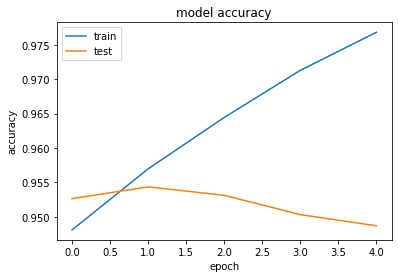

In [106]:
plt.plot(RnnHistory.history['acc'])
plt.plot(RnnHistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
import os
glove_dir = r'C:\Users\rayab\Untitled Folder'
embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.300d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.'%len(embeddings_index))

Found 400000 word vectors.


In [125]:
embedding_dim = 300
embedding_matrix = np.zeros((max_features,embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [126]:
embedding_matrix.shape

(186241, 300)

In [127]:
#model with Glove
RnnEmbedding_Dim = 300

from keras.initializers import Constant

GRUModel = Sequential()
#zero trainable params
#frozen params 300 dims * 186241 features = 55872300
GRUModel.add(layers.Embedding(max_features,RnnEmbedding_Dim,
                              embeddings_initializer = Constant(embedding_matrix),
                              trainable=False,
                              input_length=max_words))
#trainable params =  2(3(GRU's FNN) * (32 hidden units (32 hidden units+300 input)+32 hidden states)) = 63936
GRUModel.add(layers.Bidirectional(layers.GRU(units=32,return_sequences=True)))
GRUModel.add(layers.Dropout(0.25))
GRUModel.add(layers.MaxPooling1D(5))
#trainable params =  2(3(GRU's FNN) * (32 hidden units (32 hidden units+64 input)+32 hidden states)) = 18624
GRUModel.add(layers.Bidirectional(layers.GRU(units=32,return_sequences=True)))
GRUModel.add(layers.Dropout(0.25))
GRUModel.add(layers.GlobalMaxPooling1D())
GRUModel.add(layers.Dense(1,activation='sigmoid'))

GRUModel.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['acc'])
print(GRUModel.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 69, 300)           55872300  
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 69, 64)            63936     
_________________________________________________________________
dropout_15 (Dropout)         (None, 69, 64)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 13, 64)            18624     
_________________________________________________________________
dropout_16 (Dropout)         (None, 13, 64)            0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)                0         
__________

In [128]:
history1 = GRUModel.fit(x_train_features,y_train, epochs=5, batch_size=1024,
          validation_data=(x_test_features, y_test))

Train on 1044309 samples, validate on 261078 samples
Epoch 1/5
1044309/1044309 [==============================] - 519s 497us/step - loss: 0.1412 - acc: 0.9489 - val_loss: 0.1259 - val_acc: 0.9534
Epoch 2/5
1044309/1044309 [==============================] - 463s 443us/step - loss: 0.1167 - acc: 0.9543 - val_loss: 0.1286 - val_acc: 0.9539
Epoch 3/5
1044309/1044309 [==============================] - 466s 446us/step - loss: 0.1124 - acc: 0.9558 - val_loss: 0.1183 - val_acc: 0.9549
Epoch 4/5
1044309/1044309 [==============================] - 471s 451us/step - loss: 0.1096 - acc: 0.9566 - val_loss: 0.1204 - val_acc: 0.9551
Epoch 5/5
1044309/1044309 [==============================] - 474s 454us/step - loss: 0.1071 - acc: 0.9575 - val_loss: 0.1153 - val_acc: 0.9551


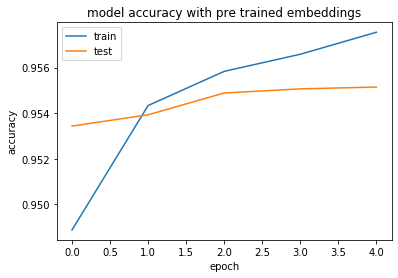

In [129]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy with pre trained embeddings')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [130]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [132]:
preds = GRUModel.predict(x_test_features)

In [133]:
preds

array([[0.01290813],
       [0.10378985],
       [0.00796754],
       ...,
       [0.01165336],
       [0.0031987 ],
       [0.03987068]], dtype=float32)

In [134]:
from sklearn.metrics import roc_auc_score,roc_curve

In [139]:
fpr, tpr, thresholds = roc_curve(y_test,preds)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_predict  = [1 if o>optimal_threshold else 0 for o in preds]


In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[219858  25067]
 [  1851  14302]]


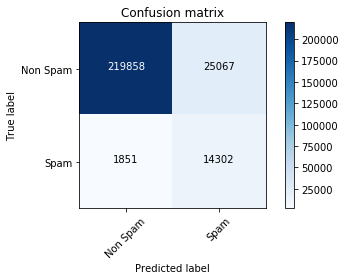

In [144]:
cnf_matrix = confusion_matrix(y_test,y_predict)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non Spam','Spam'], normalize=False,
                      title='Confusion matrix')